Trying out grouping highly correlated variables together. Seems to pretty negatively impact almost all the models, so will not be continuing down this path.

# Imports

In [2]:
import pandas as pd
import numpy as np

pd.set_option('display.max_columns',100)

In [3]:
from matplotlib import pyplot as plt
import seaborn as sns

In [4]:
from sklearn.model_selection import cross_validate, GridSearchCV

In [5]:
import statsmodels.api as sm

In [6]:
from sklearn.pipeline import make_pipeline

In [7]:
from sklearn.preprocessing import StandardScaler

In [8]:
from sklearn.preprocessing import RobustScaler

In [9]:
from sklearn.model_selection import cross_validate

In [10]:
df_raw = pd.read_csv('train.csv')

Notes:
- Year Sold and Built not useful by itself, need to be changed into Age at Sale
- Year Sold minus Year Remodel gives time since last remodel
- MSSubClass will need some encoding (one-hot)
- MSZoning will need encoding
- Street can be one hot encoded
- Alley will be encoded
- LotShape encoded
- LandContour encoded
- Utilities encode

## Data Transforms

In [11]:
df = df_raw.copy()

In [12]:
df['AgeHouseAtSale'] = df['YrSold'] - df['YearBuilt']

df['YearsLastRemodelAtSale']  = df['YrSold'] - df['YearRemodAdd']

df['YearsGarageBuiltAtSale'] = df['YrSold'] - df['GarageYrBlt'] 

df.drop(columns=['Id'],inplace=True)

df['MSSubClass'] = df['MSSubClass'].astype(str)

In [13]:
df['YearsLastRemodelAtSale'] = np.maximum(df['YearsLastRemodelAtSale'],0)

In [14]:
for var in df.dtypes[df.dtypes == 'int64'].index:
    if df[var].isnull().sum()>0:
        df[var+'_isnull'] = df[var].isnull().astype(int)
        df[var]=df[var].fillna(df[var].mean())

for var in df.dtypes[df.dtypes == 'float64'].index:
    if df[var].isnull().sum()>0:
        df[var+'_isnull'] = df[var].isnull().astype(int)
        df[var]=df[var].fillna(df[var].mean())

df_dummies = pd.get_dummies(df,dummy_na=True,drop_first=False)

In [15]:
df_dummies.drop(columns=df_dummies.loc[:,df_dummies.nunique() == 1].columns, inplace=True)

In [16]:
X = df_dummies.drop(columns='SalePrice')

y = np.log(df_dummies['SalePrice'])

X['intercept'] = 1

## Looking at effects of Robust Scaler
Not a huge fan, less explainable and causes convergence issues for Lasso

In [17]:
standardscaler = RobustScaler()

In [18]:
standardscaler.fit(X)

RobustScaler()

In [19]:
test = standardscaler.transform(X)

In [20]:
test = pd.DataFrame(test,columns=X.columns)

In [21]:
test.describe()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,AgeHouseAtSale,YearsLastRemodelAtSale,YearsGarageBuiltAtSale,LotFrontage_isnull,MasVnrArea_isnull,GarageYrBlt_isnull,YearsGarageBuiltAtSale_isnull,MSSubClass_120,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,...,GarageType_nan,GarageFinish_Fin,GarageFinish_RFn,GarageFinish_Unf,GarageFinish_nan,GarageQual_Ex,GarageQual_Fa,GarageQual_Gd,GarageQual_Po,GarageQual_TA,GarageQual_nan,GarageCond_Ex,GarageCond_Fa,GarageCond_Gd,GarageCond_Po,GarageCond_TA,GarageCond_nan,PavedDrive_N,PavedDrive_P,PavedDrive_Y,PoolQC_Ex,PoolQC_Fa,PoolQC_Gd,PoolQC_nan,Fence_GdPrv,Fence_GdWo,Fence_MnPrv,Fence_MnWw,Fence_nan,MiscFeature_Gar2,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,MiscFeature_nan,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,intercept
count,1.460000e+03,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1.460000e+03,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1.460000e+03,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.0
mean,-3.023076e-16,0.256504,0.049658,0.575342,-0.037656,-0.246872,0.631265,0.084436,46.549315,0.153402,0.131203,0.148506,0.476638,5.844521,0.079511,0.425342,0.057534,-0.434932,0.382877,-0.133562,0.046575,0.258904,-0.386986,2.405382e-15,-0.232877,-0.029068,0.560979,0.318533,21.954110,3.409589,15.060959,2.758904,43.489041,0.107306,-0.092123,0.033651,0.241910,9.923569e-18,0.177397,0.005479,0.055479,0.055479,0.059589,0.043151,0.006849,0.020548,0.367123,0.047260,0.002740,0.008219,...,0.055479,0.241096,0.289041,0.414384,0.055479,0.002055,0.032877,0.009589,0.002055,-0.102055,0.055479,0.001370,0.023973,0.006164,0.004795,-0.091781,0.055479,0.061644,0.020548,-0.082192,0.001370,0.001370,0.002055,-0.004795,0.040411,0.036986,0.107534,0.007534,-0.192466,0.001370,0.001370,0.033562,0.000685,-0.036986,0.029452,0.002740,0.001370,0.006164,0.003425,0.003425,0.083562,0.002055,-0.132192,0.069178,0.002740,0.008219,0.013699,-0.179452,0.085616,0.0
std,1.159159e+00,2.465728,0.691498,1.112799,0.656585,0.557984,1.099355,0.640362,161.319273,0.755328,0.873045,0.759132,0.599627,48.623081,0.811866,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,0.812697,0.644666,6.152457e-01,0.747315,0.885320,0.746064,0.974353,61.119149,29.317331,55.757415,40.177307,496.123024,0.901209,0.664048,0.657612,0.557834,6.161716e-01,0.382135,0.073846,0.228992,0.228992,0.236805,0.203266,0.082505,0.141914,0.482186,0.212268,0.052289,0.0903

## Creating own scaler

Based on taking the log first (adding a 1 so that 0s become 1s), and then centering and dividing out the standard deviation

The log standard is incredibly promising for Elastic Net. In fact, it's almost the best performing model yet (only beaten by the stacking regression)

Bayesian Ridge also showed improvement

Will figure out how to not affect binary vars once I move to the interpretability stage

In [44]:
from sklearn.compose import ColumnTransformer

In [22]:
from sklearn.base import BaseEstimator, TransformerMixin

class LogStandardScaler(BaseEstimator, TransformerMixin):
    def __init__(self): # no *args or **kargs
        self.init = True
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X, y=None):
        temp = np.log(X+1)
        X_scaled = (temp - temp.mean())/temp.std()
        return X_scaled.fillna(0)


In [23]:
test_scaler = LogStandardScaler()

In [53]:
test_column = ColumnTransformer(transformers=[('logStandardScaler', test_scaler, X_scaled.loc[:,X_scaled.nunique() >2].columns)])

In [61]:
test_scaler.fit(X)

LogStandardScaler()

In [62]:
X_scaled=test_scaler.transform(X)

In [63]:
pd.DataFrame(X_scaled).describe()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,AgeHouseAtSale,YearsLastRemodelAtSale,YearsGarageBuiltAtSale,LotFrontage_isnull,MasVnrArea_isnull,GarageYrBlt_isnull,YearsGarageBuiltAtSale_isnull,MSSubClass_120,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,...,GarageType_nan,GarageFinish_Fin,GarageFinish_RFn,GarageFinish_Unf,GarageFinish_nan,GarageQual_Ex,GarageQual_Fa,GarageQual_Gd,GarageQual_Po,GarageQual_TA,GarageQual_nan,GarageCond_Ex,GarageCond_Fa,GarageCond_Gd,GarageCond_Po,GarageCond_TA,GarageCond_nan,PavedDrive_N,PavedDrive_P,PavedDrive_Y,PoolQC_Ex,PoolQC_Fa,PoolQC_Gd,PoolQC_nan,Fence_GdPrv,Fence_GdWo,Fence_MnPrv,Fence_MnWw,Fence_nan,MiscFeature_Gar2,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,MiscFeature_nan,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,intercept
count,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1.460000e+03
mean,2.380900e-14,4.933401e-15,-6.560004e-14,-4.113521e-14,-9.143495e-14,2.242042e-14,-8.323631e-16,1.150678e-15,1.289684e-16,2.523058e-15,-4.532105e-15,-3.216035e-14,1.963422e-16,-1.847457e-16,-1.521705e-14,-1.687539e-15,1.558495e-16,-8.796312e-15,-1.612409e-15,9.896041e-14,2.716214e-13,-6.905834e-14,4.611836e-15,-7.393054e-13,-2.324077e-14,5.914067e-15,1.171513e-15,-1.297060e-15,-1.307554e-16,-2.865288e-16,4.486518e-18,9.509707e-16,3.201397e-16,-3.141897e-14,1.023335e-11,-3.168318e-15,-1.922207e-15,7.846843e-16,-9.236903e-16,-6.872357e-17,-2.002584e-16,-2.002584e-16,-0.000025,-0.000025,-0.000005,0.000031,-0.000270,-0.000051,-0.000003,-0.000005,...,0.000095,0.000175,0.000292,-0.000108,0.000095,-0.000002,-0.000010,0.000051,-0.000002,0.000191,0.000095,-0.000002,0.000045,-0.000039,0.000036,-0.000802,0.000095,-0.000083,0.000031,0.000738,-0.000002,-0.000002,-0.000002,0.001954,0.000031,0.000077,-0.000117,0.000027,-0.000538,-0.000002,-0.000002,0.000005,-0.000001,-0.001942,0.000039,-0.000003,-0.000002,-0.000039,-0.000003,-0.000003,0.000083,-0.000002,0.000598,0.000126,-0.000003,-0.000005,-0.000006,0.000327,-0.000125,9.996575e-01
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,

## Correlations, Grouping, and Interactions

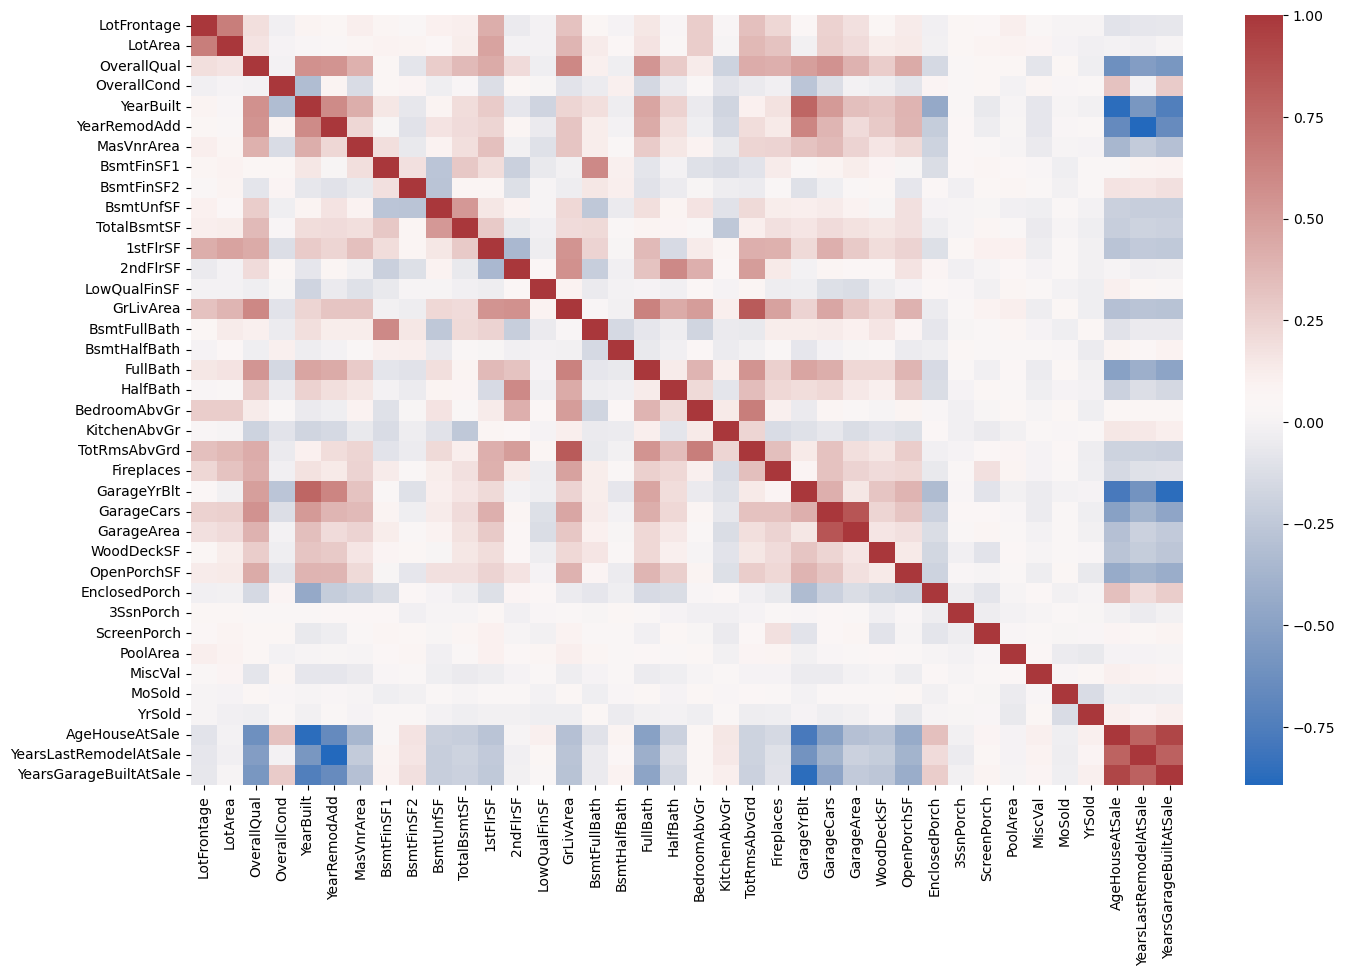

In [43]:
plt.figure(figsize=(16,10))
sns.heatmap(X_scaled[X_scaled.loc[:,X_scaled.nunique() >2].columns].corr(),cmap=sns.color_palette('vlag', as_cmap=True))
plt.show()

### Finding Metric Groups

In [59]:
import pandas as pd
import numpy as np
import os
from collections import Counter
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import squareform


def find_correlation_clusters(corr,corr_thresh):
    dissimilarity = 1.0 - corr
    hierarchy = linkage(squareform(dissimilarity), method='single')
    diss_thresh = 1.0 - corr_thresh
    labels = fcluster(hierarchy, diss_thresh, criterion='distance')
    return labels

def relabel_clusters(labels,metric_columns):
    cluster_count = Counter(labels)
    cluster_order = {cluster[0]: idx for idx, cluster in enumerate(cluster_count.most_common())}
    relabeled_clusters = [cluster_order[l] for l in labels]
    relabled_count = Counter(relabeled_clusters)
    labeled_column_df = pd.DataFrame({'group': relabeled_clusters, 'column': metric_columns}).sort_values(
        ['group', 'column'], ascending=[True, True])
    return labeled_column_df, relabled_count

def make_load_matrix(labeled_column_df,metric_columns,relabled_count,corr):
    load_mat = np.zeros((len(metric_columns), len(relabled_count)))
    for row in labeled_column_df.iterrows():
        orig_col = metric_columns.index(row[1][1])
        if relabled_count[row[1][0]]>1:
            load_mat[orig_col, row[1][0]] = 1.0/  (np.sqrt(corr) * float(relabled_count[row[1][0]])  )
        else:
            load_mat[orig_col, row[1][0]] = 1.0

    is_group = load_mat.astype(bool).sum(axis=0) > 1
    column_names=['metric_group_{}'.format(d + 1) if is_group[d]
                      else labeled_column_df.loc[labeled_column_df['group']==d,'column'].iloc[0]
                      for d in range(0, load_mat.shape[1])]
    loadmat_df = pd.DataFrame(load_mat, index=metric_columns, columns=column_names)
    loadmat_df['name'] = loadmat_df.index
    sort_cols = list(loadmat_df.columns.values)
    sort_order = [False] * loadmat_df.shape[1]
    sort_order[-1] = True
    loadmat_df = loadmat_df.sort_values(sort_cols, ascending=sort_order)
    loadmat_df = loadmat_df.drop('name', axis=1)
    return loadmat_df

def save_load_matrix(data_set_path,loadmat_df, labeled_column_df):
    save_path = data_set_path.replace('.csv', '_load_mat.csv')
    print('saving loadings to ' + save_path)
    loadmat_df.to_csv(save_path)
    save_path = data_set_path.replace('.csv', '_groupmets.csv')
    print('saving metric groups to ' + save_path)
    group_lists=['|'.join(labeled_column_df[labeled_column_df['group']==g]['column'])
                    for g in set(labeled_column_df['group'])]
    pd.DataFrame(group_lists,index=loadmat_df.columns.values,columns=['metrics']).to_csv(save_path)

def find_metric_groups(data_set_path,group_corr_thresh=0.5):

    score_save_path=data_set_path.replace('.csv','_scores.csv')
    assert os.path.isfile(score_save_path),'You must run listing 5.3 or 7.5 to save metric scores first'
    score_data = pd.read_csv(score_save_path,index_col=[0,1])
    score_data.drop('is_churn',axis=1,inplace=True)
    metric_columns = list(score_data.columns.values)

    labels = find_correlation_clusters(score_data.corr(),group_corr_thresh)
    labeled_column_df, relabled_count = relabel_clusters(labels,metric_columns)
    loadmat_df = make_load_matrix(labeled_column_df, metric_columns, relabled_count,group_corr_thresh)
    save_load_matrix(data_set_path,loadmat_df,labeled_column_df)

In [115]:
group_corr_thresh=0.6
metric_columns= list(X_scaled.loc[:,X_scaled.nunique() >2].columns.values)

labels = find_correlation_clusters(X_scaled[metric_columns].corr(),corr_thresh=group_corr_thresh)

labeled_column_df, relabled_count = relabel_clusters(labels,X_scaled.loc[:,X_scaled.nunique() >2].columns)

loadmat_df = make_load_matrix(labeled_column_df, metric_columns, relabled_count, group_corr_thresh)

group_lists=['|'.join(labeled_column_df[labeled_column_df['group']==g]['column'])
                    for g in set(labeled_column_df['group'])]

In [135]:
group_lists

['BedroomAbvGr|FullBath|GrLivArea|OverallQual|TotRmsAbvGrd',
 'GarageYrBlt|YearBuilt|YearRemodAdd',
 'AgeHouseAtSale|YearsGarageBuiltAtSale|YearsLastRemodelAtSale',
 'LotArea|LotFrontage',
 'GarageArea|GarageCars',
 'OverallCond',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'BsmtFullBath',
 'BsmtHalfBath',
 'HalfBath',
 'KitchenAbvGr',
 'Fireplaces',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal',
 'MoSold',
 'YrSold']

In [91]:
pd.DataFrame(group_lists,index=loadmat_df.columns.values,columns=['metrics'])

,metrics
metric_group_1,1stFlrSF|2ndFlrSF|BedroomAbvGr|FullBath|Garage...
metric_group_2,AgeHouseAtSale|YearsGarageBuiltAtSale|YearsLas...
metric_group_3,LotArea|LotFrontage
metric_group_4,BsmtFinSF1|BsmtFullBath
metric_group_5,BsmtUnfSF|TotalBsmtSF
OverallCond,OverallCond
MasVnrArea,MasVnrArea
BsmtFinSF2,BsmtFinSF2
LowQualFinSF,LowQualFinSF
BsmtHalfBath,BsmtHalfBath


In [117]:
def apply_metric_groups(data_set_path):

    score_save_path=data_set_path.replace('.csv','_scores.csv')
    assert os.path.isfile(score_save_path),'You must run listing 5.3 or 7.5 to save metric scores first'
    score_data = pd.read_csv(score_save_path,index_col=[0,1])
    data_2group = score_data.drop('is_churn',axis=1)

    load_mat_path = data_set_path.replace('.csv', '_load_mat.csv')
    assert os.path.isfile(load_mat_path),'You must run listing 6.4 to save a loading matrix first'
    load_mat_df = pd.read_csv(load_mat_path, index_col=0)
    load_mat_ndarray = load_mat_df.to_numpy()

    # Make sure the data is in the same column order as the rows of the loading matrix
    ndarray_2group = data_2group[load_mat_df.index.values].to_numpy()
    grouped_ndarray = np.matmul(ndarray_2group, load_mat_ndarray)

    churn_data_grouped = pd.DataFrame(grouped_ndarray,columns=load_mat_df.columns.values, index=score_data.index)

    churn_data_grouped['is_churn'] = score_data['is_churn']

    save_path = data_set_path.replace('.csv', '_groupscore.csv')
    churn_data_grouped.to_csv(save_path,header=True)
    print('Saved grouped data  to ' + save_path)

In [156]:
loadmat_df.index.values

array(['BedroomAbvGr', 'FullBath', 'GrLivArea', 'OverallQual',
       'TotRmsAbvGrd', 'GarageYrBlt', 'YearBuilt', 'YearRemodAdd',
       'AgeHouseAtSale', 'YearsGarageBuiltAtSale',
       'YearsLastRemodelAtSale', 'LotArea', 'LotFrontage', 'GarageArea',
       'GarageCars', 'OverallCond', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'BsmtFullBath', 'BsmtHalfBath', 'HalfBath',
       'KitchenAbvGr', 'Fireplaces', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold'], dtype=object)

In [142]:
load_mat_ndarray = loadmat_df.to_numpy()
ndarray_2group = X_scaled[loadmat_df.index.values].to_numpy()
grouped_ndarray = np.matmul(ndarray_2group, load_mat_ndarray)

In [143]:
df_grouped = pd.DataFrame(grouped_ndarray,columns=loadmat_df.columns.values, index=X_scaled.index)

In [148]:
df_grouped = pd.merge(
    df_grouped
    ,X_scaled.loc[:,~(X_scaled.nunique() >2)]
    ,left_index=True
    ,right_index=True
)

In [149]:
df_grouped

,metric_group_1,metric_group_2,metric_group_3,metric_group_4,metric_group_5,OverallCond,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,BsmtFullBath,BsmtHalfBath,HalfBath,KitchenAbvGr,Fireplaces,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,LotFrontage_isnull,MasVnrArea_isnull,GarageYrBlt_isnull,YearsGarageBuiltAtSale_isnull,MSSubClass_120,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSZoning_C (all),MSZoning_FV,MSZoning_RH,...,GarageType_nan,GarageFinish_Fin,GarageFinish_RFn,GarageFinish_Unf,GarageFinish_nan,GarageQual_Ex,GarageQual_Fa,GarageQual_Gd,GarageQual_Po,GarageQual_TA,GarageQual_nan,GarageCond_Ex,GarageCond_Fa,GarageCond_Gd,GarageCond_Po,GarageCond_TA,GarageCond_nan,PavedDrive_N,PavedDrive_P,PavedDrive_Y,PoolQC_Ex,PoolQC_Fa,PoolQC_Gd,PoolQC_nan,Fence_GdPrv,Fence_GdWo,Fence_MnPrv,Fence_MnWw,Fence_nan,MiscFeature_Gar2,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,MiscFeature_nan,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,intercept
0,0.833463,1.264496,-1.045882,-0.142268,0.474179,-0.460250,1.192665,0.779164,-0.355221,-0.340394,0.002512,-0.803370,1.180124,-0.133557,1.148394,-0.242840,1.258149,-0.207536,-1.013214,-0.946377,0.844919,-0.404106,-0.128477,-0.292669,-0.069369,-0.190416,-1.908671,0.139058,-0.464226,-0.074202,-0.242277,-0.242277,-0.251673,-0.212229,-0.083044,-0.144684,-0.761314,-0.222637,-0.052399,-0.091009,-0.330874,1.968614,-0.206893,-0.105241,-0.203266,-0.117808,-0.192189,-0.083044,-0.215764,-0.105241,...,-0.242308,-0.562911,1.567935,-0.841315,-0.242308,-0.045372,-0.184353,-0.098351,-0.045372,0.337209,-0.242308,-0.03701,-0.156646,-0.07881,-0.069347,0.317073,-0.242308,-0.256406,-0.144684,0.3,-0.03701,-0.03701,-0.045372,0.071338,-0.205094,-0.195713,-0.347159,-0.087087,0.487500,-0.03701,-0.03701,-0.186339,-0.026177,0.194030,-0.174128,-0.052399,-0.03701,-0.07881,-0.058594,-0.058594,-0.301845,-0.045372,0.390852,-0.272365,-0.052399,-0.091009,-0.117808,0.467890,-0.306167,0.999657
1,0.124715,-0.154344,0.634858,0.436932,0.396681,1.947496,-0.815680,0.887953,-0.355221,0.002218,0.340998,0.418335,-0.869819,-0.133557,-0.832940,4.020075,-0.769375,-0.207536,0.743101,1.249112,-1.072549,-0.404106,-0.128477,-0.292669,-0.069369,-0.190416,-0.279805,-0.614042,-0.464226,-0.074202,-0.242277,-0.242277,-0.251673,-0.212229,-0.083044,-0.144684,1.311679,-0.222637,-0.052399,-0.091009,-0.330874,-0.507411,-0.206893,-0.105241,-0.203266,-0.117808,-0.192189,-0.083044,-0.215764,-0.105241,...,-0.242308,-0.562911,1.567935,-0.841315,-0.242308,-0.045372,-0.184353,-0.098351,-0.045372,0.337209,-0.242308,-0.03701,-0.156646,-0.07881,-0.069347,0.317073,-0.242308,-0.256406,-0.144684,0.3,-0.03701,-0.03701,-0.045372,0.071338,-0.205094,-0.195713,-0.347159,-0.087087,0.487500,-0.03701,-0.03701,-0.186339,-0.026177,0.194030,-0.174128,-0.052399,-0.03701,-0.07881,-0.058594,-0.058594,-0.301845,-0.045372,0.390852,-0.272365,-0.052399,-0.091009,-0.117808,0.467890,-0.306167,0.999657
2,0.564258,1.180670,-0.801603,0.305944,0.520189,-0.460250,1.120646,0.654579,-0.355221,0.230293,0.065374,-0.576479,1.184356,-0.133557,1.148394,-0.242840,1.258149,-0.207536,0.743101,-0.946377,0.674906,-0.404106,-0.128477,-0.292669,-0.069369,-0.190416,0.920613,0.139058,-0.464226,-0.074202,-0.242277,-0.242277,-0.251673,-0.212229,-0.083044,-0.144684,-0.761314,-0.222637,-0.052399,-0.091009,-0.330874,1.968614,-0.206893,-0.105241,-0.203266,-0.117808,-0.192189,-0.083044,-0.215764,-0.105241,...,-0.242308,-0.562911,1.567935,-0.841315,-0.242308,-0.045372,-0.184353,-0.098351,-0.045372,0.337209,-0.242308,-0.03701,-0.156646,-0.07881,-0.069347,0.317073,-0.242308,-0

In [150]:
from sklearn.base import BaseEstimator, TransformerMixin

class CorrelationGrouper(BaseEstimator, TransformerMixin):
    def __init__(self): # no *args or **kargs
        self.init = True
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X, y=None):
        group_corr_thresh=0.6
        metric_columns= list(X.loc[:,X.nunique() >2].columns.values)

        labels = find_correlation_clusters(X[metric_columns].corr(),corr_thresh=group_corr_thresh)

        labeled_column_df, relabled_count = relabel_clusters(labels,X.loc[:,X.nunique() >2].columns)

        loadmat_df = make_load_matrix(labeled_column_df, metric_columns, relabled_count, group_corr_thresh)

        group_lists=['|'.join(labeled_column_df[labeled_column_df['group']==g]['column'])
                            for g in set(labeled_column_df['group'])]

        load_mat_ndarray = loadmat_df.to_numpy()
        ndarray_2group = X[loadmat_df.index.values].to_numpy()
        grouped_ndarray = np.matmul(ndarray_2group, load_mat_ndarray)
        df_grouped = pd.DataFrame(grouped_ndarray,columns=loadmat_df.columns.values, index=X.index)
        
        df_grouped = pd.merge(
            df_grouped
            ,X.loc[:,~(X_scaled.nunique() >2)]
            ,left_index=True
            ,right_index=True
        )
        return df_grouped
        

In [151]:
cor_grouper = CorrelationGrouper()

In [153]:
cor_grouper.fit(X_scaled)

CorrelationGrouper()

In [154]:
cor_grouper.transform(X_scaled)

,metric_group_1,metric_group_2,metric_group_3,metric_group_4,metric_group_5,OverallCond,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,BsmtFullBath,BsmtHalfBath,HalfBath,KitchenAbvGr,Fireplaces,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,LotFrontage_isnull,MasVnrArea_isnull,GarageYrBlt_isnull,YearsGarageBuiltAtSale_isnull,MSSubClass_120,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSZoning_C (all),MSZoning_FV,MSZoning_RH,...,GarageType_nan,GarageFinish_Fin,GarageFinish_RFn,GarageFinish_Unf,GarageFinish_nan,GarageQual_Ex,GarageQual_Fa,GarageQual_Gd,GarageQual_Po,GarageQual_TA,GarageQual_nan,GarageCond_Ex,GarageCond_Fa,GarageCond_Gd,GarageCond_Po,GarageCond_TA,GarageCond_nan,PavedDrive_N,PavedDrive_P,PavedDrive_Y,PoolQC_Ex,PoolQC_Fa,PoolQC_Gd,PoolQC_nan,Fence_GdPrv,Fence_GdWo,Fence_MnPrv,Fence_MnWw,Fence_nan,MiscFeature_Gar2,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,MiscFeature_nan,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,intercept
0,0.833463,1.264496,-1.045882,-0.142268,0.474179,-0.460250,1.192665,0.779164,-0.355221,-0.340394,0.002512,-0.803370,1.180124,-0.133557,1.148394,-0.242840,1.258149,-0.207536,-1.013214,-0.946377,0.844919,-0.404106,-0.128477,-0.292669,-0.069369,-0.190416,-1.908671,0.139058,-0.464226,-0.074202,-0.242277,-0.242277,-0.251673,-0.212229,-0.083044,-0.144684,-0.761314,-0.222637,-0.052399,-0.091009,-0.330874,1.968614,-0.206893,-0.105241,-0.203266,-0.117808,-0.192189,-0.083044,-0.215764,-0.105241,...,-0.242308,-0.562911,1.567935,-0.841315,-0.242308,-0.045372,-0.184353,-0.098351,-0.045372,0.337209,-0.242308,-0.03701,-0.156646,-0.07881,-0.069347,0.317073,-0.242308,-0.256406,-0.144684,0.3,-0.03701,-0.03701,-0.045372,0.071338,-0.205094,-0.195713,-0.347159,-0.087087,0.487500,-0.03701,-0.03701,-0.186339,-0.026177,0.194030,-0.174128,-0.052399,-0.03701,-0.07881,-0.058594,-0.058594,-0.301845,-0.045372,0.390852,-0.272365,-0.052399,-0.091009,-0.117808,0.467890,-0.306167,0.999657
1,0.124715,-0.154344,0.634858,0.436932,0.396681,1.947496,-0.815680,0.887953,-0.355221,0.002218,0.340998,0.418335,-0.869819,-0.133557,-0.832940,4.020075,-0.769375,-0.207536,0.743101,1.249112,-1.072549,-0.404106,-0.128477,-0.292669,-0.069369,-0.190416,-0.279805,-0.614042,-0.464226,-0.074202,-0.242277,-0.242277,-0.251673,-0.212229,-0.083044,-0.144684,1.311679,-0.222637,-0.052399,-0.091009,-0.330874,-0.507411,-0.206893,-0.105241,-0.203266,-0.117808,-0.192189,-0.083044,-0.215764,-0.105241,...,-0.242308,-0.562911,1.567935,-0.841315,-0.242308,-0.045372,-0.184353,-0.098351,-0.045372,0.337209,-0.242308,-0.03701,-0.156646,-0.07881,-0.069347,0.317073,-0.242308,-0.256406,-0.144684,0.3,-0.03701,-0.03701,-0.045372,0.071338,-0.205094,-0.195713,-0.347159,-0.087087,0.487500,-0.03701,-0.03701,-0.186339,-0.026177,0.194030,-0.174128,-0.052399,-0.03701,-0.07881,-0.058594,-0.058594,-0.301845,-0.045372,0.390852,-0.272365,-0.052399,-0.091009,-0.117808,0.467890,-0.306167,0.999657
2,0.564258,1.180670,-0.801603,0.305944,0.520189,-0.460250,1.120646,0.654579,-0.355221,0.230293,0.065374,-0.576479,1.184356,-0.133557,1.148394,-0.242840,1.258149,-0.207536,0.743101,-0.946377,0.674906,-0.404106,-0.128477,-0.292669,-0.069369,-0.190416,0.920613,0.139058,-0.464226,-0.074202,-0.242277,-0.242277,-0.251673,-0.212229,-0.083044,-0.144684,-0.761314,-0.222637,-0.052399,-0.091009,-0.330874,1.968614,-0.206893,-0.105241,-0.203266,-0.117808,-0.192189,-0.083044,-0.215764,-0.105241,...,-0.242308,-0.562911,1.567935,-0.841315,-0.242308,-0.045372,-0.184353,-0.098351,-0.045372,0.337209,-0.242308,-0.03701,-0.156646,-0.07881,-0.069347,0.317073,-0.242308,-0

# Training

## SKLEARN

In [157]:
from sklearn.linear_model import LassoCV

In [158]:
lasso_cv = LassoCV(cv=5, random_state=0,max_iter=2000)

In [159]:
lasso_pipeline = make_pipeline(LogStandardScaler(),
                               CorrelationGrouper(),
                               lasso_cv)

In [160]:
lasso_pipeline.fit(X=X,y=y)

Pipeline(steps=[('logstandardscaler', LogStandardScaler()),
                ('correlationgrouper', CorrelationGrouper()),
                ('lassocv', LassoCV(cv=5, max_iter=2000, random_state=0))])

In [161]:
lasso_cv.alpha_

0.004787734486296429

### Elastic Net
Looks like the optimal is just an L1 Lasso regression

In [176]:
from sklearn.linear_model import ElasticNetCV

In [177]:
# elastic_net_cv = ElasticNetCV(l1_ratio=[0,.5,1]
#                              ,alphas=[0.1,1,10,100]
#                              )
elastic_net_cv = ElasticNetCV(cv=5, random_state=0, l1_ratio=[0.5,0.7,0.8,0.9,1],max_iter=2000)

In [178]:
elastic_net_pipeline = make_pipeline(LogStandardScaler(),
                                    CorrelationGrouper(),
                                     elastic_net_cv)

In [179]:
elastic_net_pipeline.fit(X=X,y=y)

Pipeline(steps=[('logstandardscaler', LogStandardScaler()),
                ('correlationgrouper', CorrelationGrouper()),
                ('elasticnetcv',
                 ElasticNetCV(cv=5, l1_ratio=[0.5, 0.7, 0.8, 0.9, 1],
                              max_iter=2000, random_state=0))])

In [180]:
elastic_net_cv.l1_ratio_

0.5

In [181]:
elastic_net_cv.alpha_

0.009575468972592859

### Decision Tree

In [27]:
params_dt={'splitter':['random', 'best']
        ,'min_samples_split':[2, 3, 4, 5, 6, 8, 10]
        ,'min_samples_leaf':[0.01, 0.02, 0.03, 0.04]
        ,'min_impurity_decrease':[0.0, 0.0005, 0.005, 0.05, 0.10, 0.15, 0.2]
        ,'max_leaf_nodes':[10, 15, 20, 25, 30, 35, 40, 45, 50, None]
        ,'max_features':[ 0.95, 0.90, 0.85, 0.80, 0.75, 0.70]
        ,'max_depth':[None, 2,4,6,8]
        ,'min_weight_fraction_leaf':[0.0, 0.0025, 0.005, 0.0075, 0.01, 0.05]}
        

In [49]:
from sklearn.tree import DecisionTreeRegressor

In [50]:
from sklearn.model_selection import RandomizedSearchCV

In [51]:
from skopt import BayesSearchCV

In [31]:
decision_tree = DecisionTreeRegressor()

In [32]:
bayes_search_dt = BayesSearchCV(decision_tree,params_dt)

In [218]:
decision_tree = DecisionTreeRegressor(max_depth=6, max_features=0.85, max_leaf_nodes=40,
                      min_samples_leaf=0.02, min_samples_split=6,
                      min_weight_fraction_leaf=0.0075)

In [219]:
decision_tree_pipeline = make_pipeline(LogStandardScaler(),decision_tree)

In [220]:
decision_tree_pipeline.fit(X,y)

Pipeline(steps=[('logstandardscaler', LogStandardScaler()),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(max_depth=6, max_features=0.85,
                                       max_leaf_nodes=40, min_samples_leaf=0.02,
                                       min_samples_split=6,
                                       min_weight_fraction_leaf=0.0075))])

## XGBoost

In [185]:
import xgboost

In [186]:
from importlib import reload

In [187]:
reload(xgboost)

<module 'xgboost' from 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\xgboost\\__init__.py'>

In [188]:
xgboost.__version__

'1.6.2'

In [189]:
xg_boost = xgboost.XGBRegressor()

In [190]:
xg_boost_pipeline = make_pipeline(LogStandardScaler(),
                                  CorrelationGrouper(),
                                  xg_boost)

In [191]:
xg_boost_pipeline.fit(X,y)

Pipeline(steps=[('logstandardscaler', LogStandardScaler()),
                ('correlationgrouper', CorrelationGrouper()),
                ('xgbregressor',
                 XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              gamma=0, gpu_id=-1, grow_policy='depthwise',
                              importance_type=None, interaction_constraints='',
                              learning_rate=0.300000012, max_bin=256,
                              max_cat_to_onehot=4, max_delta_step=0,
                              max_depth=6, max_leaves=0, min_child_weight=1,
                              missing=nan, monotone_constraints='()',
                              n_estimators=100, n_jobs=0, num_parallel_tree=1,
                      

## Random Forest

In [228]:
from sklearn.ensemble import RandomForestRegressor

In [229]:
random_forest_initial = RandomForestRegressor(n_estimators=200,oob_score=True)

In [230]:
random_forest_pipeline = make_pipeline(LogStandardScaler(),random_forest_initial)

In [231]:
random_forest_pipeline.fit(X,y)

Pipeline(steps=[('logstandardscaler', LogStandardScaler()),
                ('randomforestregressor',
                 RandomForestRegressor(n_estimators=200, oob_score=True))])

In [44]:
random_forest = RandomForestRegressor(max_depth=20, max_features=0.55, min_samples_leaf=6,
                      min_samples_split=0.001, min_weight_fraction_leaf=0.005,
                      n_estimators=200, oob_score=True)

NameError: name 'RandomForestRegressor' is not defined

## Adaboost

In [240]:
from sklearn.ensemble import AdaBoostRegressor

In [241]:
adaboost = AdaBoostRegressor()

In [242]:
adaboost_pipeline = make_pipeline(LogStandardScaler(),adaboost)

In [243]:
adaboost_pipeline.fit(X,y)

Pipeline(steps=[('logstandardscaler', LogStandardScaler()),
                ('adaboostregressor', AdaBoostRegressor())])

## Light GBM

In [247]:
from lightgbm import LGBMRegressor

In [248]:
light_gbm = LGBMRegressor()

light_gbm_pipeline = make_pipeline(LogStandardScaler(),light_gbm)

light_gbm_pipeline.fit(X,y)

Pipeline(steps=[('logstandardscaler', LogStandardScaler()),
                ('lgbmregressor', LGBMRegressor())])

## GradientBoostingRegressor

In [250]:
from sklearn.ensemble import GradientBoostingRegressor

In [251]:
gbr = GradientBoostingRegressor()

gbr_pipeline = make_pipeline(LogStandardScaler(),gbr)

gbr.fit(X,y)

GradientBoostingRegressor()

## Stochastic Gradient Descent Regression

In [255]:
from sklearn.linear_model import SGDRegressor

In [256]:
SGDR = SGDRegressor()

SGDR_pipeline = make_pipeline(LogStandardScaler(),SGDR)

SGDR_pipeline.fit(X,y)

Pipeline(steps=[('logstandardscaler', LogStandardScaler()),
                ('sgdregressor', SGDRegressor())])

## from sklearn.svm import SVR
Support Vector Machine

In [257]:
from sklearn.svm import SVR

In [258]:
svr = SVR()

svr_pipeline = make_pipeline(LogStandardScaler(),svr)

svr_pipeline.fit(X,y)

Pipeline(steps=[('logstandardscaler', LogStandardScaler()), ('svr', SVR())])

## from sklearn.linear_model import BayesianRidge

In [259]:
from sklearn.linear_model import BayesianRidge

In [260]:
bayesianr = BayesianRidge()

bayesianr_pipeline = make_pipeline(LogStandardScaler(),bayesianr)

bayesianr_pipeline.fit(X,y)

Pipeline(steps=[('logstandardscaler', LogStandardScaler()),
                ('bayesianridge', BayesianRidge())])

## from sklearn.kernel_ridge import KernelRidge

In [261]:
from sklearn.kernel_ridge import KernelRidge

In [262]:
kernelr = KernelRidge()

kernelr_pipeline = make_pipeline(LogStandardScaler(),kernelr)

kernelr_pipeline.fit(X,y)

Pipeline(steps=[('logstandardscaler', LogStandardScaler()),
                ('kernelridge', KernelRidge())])

## Ensemble

In [264]:
from sklearn.ensemble import VotingRegressor, StackingRegressor

In [265]:
voting_reg = VotingRegressor([('elastic_net',elastic_net_pipeline)
                              ,('rf',random_forest_pipeline)
                              ,('xg_boost',xg_boost_pipeline)
                             # ,('adaboost',adaboost_pipeline)
                                  ,('lightgbm',light_gbm_pipeline)
                                  ,('gbr',gbr_pipeline)
                                  ,('bayesianRidge',bayesianr_pipeline)
                                  # ,('kernelRidge',kernelr)
                             ])

In [266]:
voting_reg.fit(X,y)

VotingRegressor(estimators=[('elastic_net',
                             Pipeline(steps=[('logstandardscaler',
                                              LogStandardScaler()),
                                             ('elasticnetcv',
                                              ElasticNetCV(cv=5,
                                                           l1_ratio=[0.5, 0.7,
                                                                     0.8, 0.9,
                                                                     1],
                                                           max_iter=2000,
                                                           random_state=0))])),
                            ('rf',
                             Pipeline(steps=[('logstandardscaler',
                                              LogStandardScaler()),
                                             ('randomforestregressor',
                                              RandomForestRegressor(

In [274]:
stacking_reg = StackingRegressor([('elastic_net',elastic_net_pipeline)
                              ,('rf',random_forest_pipeline)
                              ,('xg_boost',xg_boost_pipeline)
                             # ,('adaboost',adaboost_pipeline)
                                  ,('lightgbm',light_gbm_pipeline)
                                  ,('gbr',gbr_pipeline)
                                  ,('bayesianRidge',bayesianr_pipeline)
                                  # ,('kernelRidge',kernelr)
                             ])

In [275]:
stacking_reg.fit(X,y)

StackingRegressor(estimators=[('elastic_net',
                               Pipeline(steps=[('logstandardscaler',
                                                LogStandardScaler()),
                                               ('elasticnetcv',
                                                ElasticNetCV(cv=5,
                                                             l1_ratio=[0.5, 0.7,
                                                                       0.8, 0.9,
                                                                       1],
                                                             max_iter=2000,
                                                             random_state=0))])),
                              ('rf',
                               Pipeline(steps=[('logstandardscaler',
                                                LogStandardScaler()),
                                               ('randomforestregressor',
                                        

## Cross Val Score

In [186]:
val_results = cross_validate(elastic_net_pipeline,X,y, scoring=['neg_mean_squared_error','r2'])
pd.DataFrame(val_results['test_neg_mean_squared_error']).describe().transpose()

,count,mean,std,min,25%,50%,75%,max
0,5.0,-0.015875,0.003899,-0.020499,-0.018528,-0.015914,-0.013897,-0.010538


In [162]:
val_results = cross_validate(lasso_pipeline,X,y, scoring=['neg_mean_squared_error','r2'])
pd.DataFrame(val_results['test_neg_mean_squared_error']).describe().transpose()

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- BsmtFinSF1
- BsmtFullBath
Feature names seen at fit time, yet now missing:
- BsmtHalfBath
- PoolArea
- metric_group_5
- metric_group_6

  warnings.warn(message, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return cache[method]
KeyError: 'predict'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761

,count,mean,std,min,25%,50%,75%,max
0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [234]:
val_results = cross_validate(decision_tree_pipeline,X,y, scoring=['neg_mean_squared_error','r2'])
pd.DataFrame(val_results['test_neg_mean_squared_error']).describe().transpose()

,count,mean,std,min,25%,50%,75%,max
0,5.0,-0.037435,0.00513,-0.042783,-0.040168,-0.039812,-0.034313,-0.0301


In [235]:
val_results = cross_validate(xg_boost_pipeline,X,y, scoring=['neg_mean_squared_error','r2'])
pd.DataFrame(val_results['test_neg_mean_squared_error']).describe().transpose()

,count,mean,std,min,25%,50%,75%,max
0,5.0,-0.020749,0.002079,-0.024063,-0.021163,-0.020198,-0.019794,-0.01853


In [244]:
val_results = cross_validate(random_forest_pipeline,X,y, scoring=['neg_mean_squared_error','r2'])
pd.DataFrame(val_results['test_neg_mean_squared_error']).describe().transpose()

,count,mean,std,min,25%,50%,75%,max
0,5.0,-0.02076,0.002691,-0.024336,-0.022615,-0.020308,-0.018525,-0.018014


In [202]:
val_results = cross_validate(random_forest_initial,X,y, scoring=['neg_mean_squared_error','r2'])
pd.DataFrame(val_results['test_neg_mean_squared_error']).describe().transpose()

,count,mean,std,min,25%,50%,75%,max
0,5.0,-0.020326,0.002785,-0.023262,-0.022594,-0.020544,-0.01874,-0.016492


In [245]:
val_results = cross_validate(adaboost_pipeline,X,y, scoring=['neg_mean_squared_error','r2'])
pd.DataFrame(val_results['test_neg_mean_squared_error']).describe().transpose()

,count,mean,std,min,25%,50%,75%,max
0,5.0,-0.031226,0.003267,-0.034848,-0.033666,-0.030606,-0.030557,-0.026451


In [252]:
val_results = cross_validate(light_gbm_pipeline,X,y, scoring=['neg_mean_squared_error','r2'])
pd.DataFrame(val_results['test_neg_mean_squared_error']).describe().transpose()

,count,mean,std,min,25%,50%,75%,max
0,5.0,-0.017907,0.002759,-0.022168,-0.01865,-0.017702,-0.015801,-0.015214


In [253]:
val_results = cross_validate(gbr_pipeline,X,y, scoring=['neg_mean_squared_error','r2'])
pd.DataFrame(val_results['test_neg_mean_squared_error']).describe().transpose()

,count,mean,std,min,25%,50%,75%,max
0,5.0,-0.016872,0.002406,-0.020477,-0.016831,-0.016738,-0.016614,-0.013699


In [267]:
val_results = cross_validate(SGDR,X,y, scoring=['neg_mean_squared_error','r2'])
pd.DataFrame(val_results['test_neg_mean_squared_error']).describe().transpose()

,count,mean,std,min,25%,50%,75%,max
0,5.0,-1.904125e+33,1.031940e+33,-3.698560e+33,-1.823122e+33,-1.471204e+33,-1.377371e+33,-1.150367e+33


In [268]:
val_results = cross_validate(svr,X,y, scoring=['neg_mean_squared_error','r2'])
pd.DataFrame(val_results['test_neg_mean_squared_error']).describe().transpose()

,count,mean,std,min,25%,50%,75%,max
0,5.0,-0.041612,0.004728,-0.045493,-0.045119,-0.042029,-0.041672,-0.033746


In [269]:
val_results = cross_validate(bayesianr_pipeline,X,y, scoring=['neg_mean_squared_error','r2'])
pd.DataFrame(val_results['test_neg_mean_squared_error']).describe().transpose()

,count,mean,std,min,25%,50%,75%,max
0,5.0,-0.017763,0.00435,-0.022834,-0.02048,-0.018978,-0.01382,-0.012706


In [271]:
val_results = cross_validate(kernelr_pipeline,X,y, scoring=['neg_mean_squared_error','r2'])
pd.DataFrame(val_results['test_neg_mean_squared_error']).describe().transpose()

,count,mean,std,min,25%,50%,75%,max
0,5.0,-577.065057,0.720064,-577.531635,-577.427471,-577.374909,-577.195793,-575.795477


In [272]:
val_results = cross_validate(voting_reg,X,y, scoring=['neg_mean_squared_error','r2'])
pd.DataFrame(val_results['test_neg_mean_squared_error']).describe().transpose()

,count,mean,std,min,25%,50%,75%,max
0,5.0,-0.014984,0.002678,-0.018672,-0.016118,-0.015262,-0.013029,-0.011838


In [91]:
val_results = cross_validate(stacking_reg,X,y, scoring=['neg_mean_squared_error','r2'])
pd.DataFrame(val_results['test_neg_mean_squared_error']).describe().transpose()

,count,mean,std,min,25%,50%,75%,max
0,5.0,-0.015611,0.003662,-0.019202,-0.019197,-0.015881,-0.012115,-0.011662


Scaling seems to have really benefitted the linear regression Elastic Net, but did not affect the tree based formulas much. 

Somehow kernalr is much worse now. 

# Prediction

In [163]:
df_predict_raw = pd.read_csv('test.csv')

In [164]:
df_predict = df_predict_raw.copy()

In [165]:
df_predict['AgeHouseAtSale'] = df_predict['YrSold'] - df_predict['YearBuilt']

df_predict['YearsLastRemodelAtSale']  = df_predict['YrSold'] - df_predict['YearRemodAdd']

df_predict['YearsGarageBuiltAtSale'] = df_predict['YrSold'] - df_predict['GarageYrBlt'] 

df_predict.drop(columns=['Id'],inplace=True)

df_predict['MSSubClass'] = df_predict['MSSubClass'].astype(str)

In [166]:
df_predict['YearsLastRemodelAtSale'] = np.maximum(df_predict['YearsLastRemodelAtSale'],0)
df_predict['AgeHouseAtSale'] = np.maximum(df_predict['AgeHouseAtSale'],0)
df_predict['YearsGarageBuiltAtSale'] = np.maximum(df_predict['YearsGarageBuiltAtSale'],0)

In [167]:
for var in df_predict.dtypes[df_predict.dtypes == 'int64'].index:
    if df_predict[var].isnull().sum()>0:
        df_predict[var+'_isnull'] = df_predict[var].isnull().astype(int)
        df_predict[var]=df_predict[var].fillna(df_predict[var].mean())

for var in df_predict.dtypes[df_predict.dtypes == 'float64'].index:
    if df_predict[var].isnull().sum()>0:
        df_predict[var+'_isnull'] = df_predict[var].isnull().astype(int)
        df_predict[var]=df_predict[var].fillna(df_predict[var].mean())

df_predict_dummies = pd.get_dummies(df_predict,dummy_na=True,drop_first=False)

In [168]:
_, df_predict_dummies = X.align(df_predict_dummies, axis=1, fill_value=0)

In [169]:
df_predict_dummies.drop(columns=df_predict_dummies.columns[~df_predict_dummies.columns.isin(X.columns)],inplace=True)

In [170]:
df_predict_dummies['intercept']=1

In [171]:
df_predict_dummies.describe()

,1stFlrSF,2ndFlrSF,3SsnPorch,AgeHouseAtSale,Alley_Grvl,Alley_Pave,Alley_nan,BedroomAbvGr,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,BsmtCond_Fa,BsmtCond_Gd,BsmtCond_Po,BsmtCond_TA,BsmtCond_nan,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtExposure_nan,BsmtFinSF1,BsmtFinSF2,BsmtFinType1_ALQ,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType1_nan,BsmtFinType2_ALQ,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_Rec,BsmtFinType2_Unf,BsmtFinType2_nan,BsmtFullBath,BsmtHalfBath,BsmtQual_Ex,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_TA,BsmtQual_nan,BsmtUnfSF,CentralAir_N,CentralAir_Y,Condition1_Artery,...,PavedDrive_Y,PoolArea,PoolQC_Ex,PoolQC_Fa,PoolQC_Gd,PoolQC_nan,RoofMatl_ClyTile,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,ScreenPorch,Street_Grvl,Street_Pave,TotRmsAbvGrd,TotalBsmtSF,Utilities_AllPub,Utilities_NoSeWa,WoodDeckSF,YearBuilt,YearRemodAdd,YearsGarageBuiltAtSale,YearsGarageBuiltAtSale_isnull,YearsLastRemodelAtSale,YrSold,intercept
count,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,...,1459.000000,1459.000000,1459.000000,1459.0,1459.000000,1459.000000,1459.0,1459.000000,1459.0,1459.0,1459.0,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.0,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.0
mean,1156.534613,325.967786,1.794380,36.412611,0.047978,0.025360,0.926662,2.854010,0.825908,0.021247,0.039068,0.036326,0.077450,0.040439,0.039068,0.002056,0.887594,0.030843,0.135024,0.097327,0.085675,0.651816,0.030158,439.203704,52.619342,0.143249,0.082934,0.295408,0.054832,0.106237,0.288554,0.028787,0.022618,0.023989,0.013708,0.028101,0.034955,0.847841,0.028787,0.434454,0.065202,0.093900,0.036326,0.405072,0.434544,0.030158,554.294925,0.069225,0.930775,0.030158,...,0.891707,1.744345,0.001371,0.0,0.000685,0.997944,0.0,0.988348,0.0,0.0,0.0,0.008225,0.002742,0.000685,0.004798,0.801234,0.007539,0.181631,0.002742,0.002056,0.061001,0.005483,0.008225,0.017820,0.825223,0.082248,0.030158,0.005483,0.002056,0.011652,0.002742,0.002056,0.080192,0.002742,0.862234,17.064428,0.004112,0.995888,6.385195,1046.117970,0.998629,0.0,93.174777,1971.357779,1983.662783,30.191166,0.053461,24.108979,2007.769705,1.0
std,398.165820,420.610226,20.207842,30.431416,0.213793,0.157269,0.260780,0.829788,0.379318,0.144258,0.193823,0.187165,0.267396,0.197053,0.193823,0.045314,0.315973,0.172952,0.341866,0.296504,0.279980,0.476558,0.171080,455.111888,176.693301,0.350447,0.275876,0.456382,0.227730,0.308247,0.453245,0.167264,0.148734,0.153067,0.116316,0.165319,0.183730,0.359298,0.167264,0.530283,0.252295,0.291789,0.187165,0.491074,0.495867,0.171080,437.110508,0.253924,

## Predictions

### Statsmodel low regularization

In [34]:
df_predict_raw['SalePrice'] = np.exp(results.predict(df_predict_dummies[X.columns]))

df_predict_raw[['Id','SalePrice']].to_csv('predictions_initial.csv',index=False)

### Elastic Net

In [173]:
df_predict_raw['SalePrice'] =  np.exp(lasso_pipeline.predict(df_predict_dummies[X.columns]))

df_predict_raw[['Id','SalePrice']].to_csv('predictions_lasso_log_corgroup.csv',index=False)

In [184]:
df_predict_raw['SalePrice'] =  np.exp(elastic_net_pipeline.predict(df_predict_dummies[X.columns]))

df_predict_raw[['Id','SalePrice']].to_csv('predictions_elasticnet_log_corgroup.csv',index=False)

### Decision Tree

In [236]:
df_predict_raw['SalePrice'] =  np.exp(decision_tree_pipeline.predict(df_predict_dummies[X.columns]))

df_predict_raw[['Id','SalePrice']].to_csv('predictions_decisiontree_logstandard.csv',index=False)

### XG Boost

In [193]:
df_predict_raw['SalePrice'] =  np.exp(xg_boost_pipeline.predict(df_predict_dummies[X.columns]))

df_predict_raw[['Id','SalePrice']].to_csv('predictions_xgboost_logcorgrouper.csv',index=False)

### Random Forest

In [198]:
df_predict_raw['SalePrice'] =  np.exp(random_forest.predict(df_predict_dummies[X.columns]))

df_predict_raw[['Id','SalePrice']].to_csv('predictions_rf_cv.csv',index=False)

In [201]:
df_predict_raw['SalePrice'] =  np.exp(random_forest_initial.predict(df_predict_dummies[X.columns]))

df_predict_raw[['Id','SalePrice']].to_csv('predictions_rf_logstandard.csv',index=False)

### Light GBM

In [278]:
df_predict_raw['SalePrice'] =  np.exp(light_gbm.predict(df_predict_dummies[X.columns]))

df_predict_raw[['Id','SalePrice']].to_csv('predictions_light_gbm.csv',index=False)

### Gradient Boosting Regression

In [282]:
df_predict_raw['SalePrice'] =  np.exp(gbr.predict(df_predict_dummies[X.columns]))

df_predict_raw[['Id','SalePrice']].to_csv('predictions_gbr.csv',index=False)

### Voting Regression

In [273]:
df_predict_raw['SalePrice'] =  np.exp(voting_reg.predict(df_predict_dummies[X.columns]))

df_predict_raw[['Id','SalePrice']].to_csv('predictions_voting_reg_standardized.csv',index=False)

### Stacking Regression

In [279]:
df_predict_raw['SalePrice'] =  np.exp(stacking_reg.predict(df_predict_dummies[X.columns]))

df_predict_raw[['Id','SalePrice']].to_csv('predictions_stacking_reg.csv',index=False)